<a href="https://colab.research.google.com/github/pelinbalci/TF_Intro/blob/main/lecture_8_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

References:

- https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%206%20-%20Lesson%203%20-%20Notebook.ipynb

- https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/

- https://www.tensorflow.org/tutorials/images/transfer_learning

- To prevent overfitting use dropout: https://www.youtube.com/watch?v=ARq74QuavAo&ab_channel=DeepLearningAI

This part is copied from: https://www.tensorflow.org/tutorials/images/transfer_learning


"You either use the pretrained model as is or use transfer learning to customize this model to a given task."

"
### Summary
- Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

- Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on."

Without dropout: 

100/100 - 18s - loss: 0.1216 - accuracy: 0.9605 - val_loss: 0.1320 - val_accuracy: 0.9700


```And the idea behind the dropout is that layers in a neural network can sometimes end up having similar weights and possible impact each other leading to over-fitting. With a big complex model like this, that's a risk.  ```

With Dropout:



In [20]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False,   # ignore the top layer 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False   # lock layers. we don't want to retrain them. 
  
pre_trained_model.summary()

--2021-05-23 15:17:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   123MB/s    in 0.7s    

2021-05-23 15:17:59 (123 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                 

In [21]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [22]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [23]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-05-23 15:18:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   155MB/s    in 0.4s    

2021-05-23 15:18:02 (155 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2)

Epoch 1/100
100/100 - 24s - loss: 0.3285 - accuracy: 0.8675 - val_loss: 0.1267 - val_accuracy: 0.9560
Epoch 2/100
100/100 - 19s - loss: 0.2021 - accuracy: 0.9255 - val_loss: 0.1420 - val_accuracy: 0.9530
Epoch 3/100
100/100 - 19s - loss: 0.1932 - accuracy: 0.9270 - val_loss: 0.1978 - val_accuracy: 0.9410
Epoch 4/100
100/100 - 18s - loss: 0.1812 - accuracy: 0.9295 - val_loss: 0.1147 - val_accuracy: 0.9640
Epoch 5/100
100/100 - 18s - loss: 0.1770 - accuracy: 0.9335 - val_loss: 0.1128 - val_accuracy: 0.9580
Epoch 6/100
100/100 - 18s - loss: 0.1512 - accuracy: 0.9490 - val_loss: 0.0993 - val_accuracy: 0.9660
Epoch 7/100
100/100 - 19s - loss: 0.1664 - accuracy: 0.9395 - val_loss: 0.1315 - val_accuracy: 0.9570
Epoch 8/100
100/100 - 19s - loss: 0.1502 - accuracy: 0.9465 - val_loss: 0.0925 - val_accuracy: 0.9710
Epoch 9/100
100/100 - 19s - loss: 0.1524 - accuracy: 0.9425 - val_loss: 0.1110 - val_accuracy: 0.9710
Epoch 10/100
100/100 - 19s - loss: 0.1443 - accuracy: 0.9440 - val_loss: 0.1400 - 

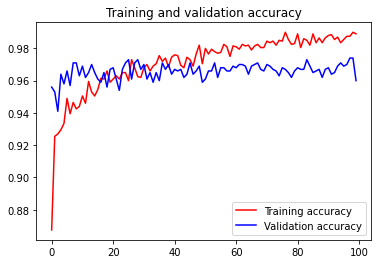

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

This is another overfitting situation.

In [26]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
xx = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
xx = layers.Dense(1024, activation='relu')(xx)
# Add a dropout rate of 0.2
xx = layers.Dropout(0.2)(xx)                  
# Add a final sigmoid layer for classification
xx = layers.Dense  (1, activation='sigmoid')(xx)           

model2 = Model( pre_trained_model.input, xx) 

model2.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [27]:
history2 = model2.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2)

Epoch 1/100
100/100 - 23s - loss: 0.3332 - accuracy: 0.8670 - val_loss: 0.1122 - val_accuracy: 0.9570
Epoch 2/100
100/100 - 18s - loss: 0.2314 - accuracy: 0.9155 - val_loss: 0.1388 - val_accuracy: 0.9540
Epoch 3/100
100/100 - 18s - loss: 0.2024 - accuracy: 0.9265 - val_loss: 0.1138 - val_accuracy: 0.9620
Epoch 4/100
100/100 - 18s - loss: 0.2023 - accuracy: 0.9280 - val_loss: 0.1227 - val_accuracy: 0.9540
Epoch 5/100
100/100 - 18s - loss: 0.1910 - accuracy: 0.9370 - val_loss: 0.1171 - val_accuracy: 0.9570
Epoch 6/100
100/100 - 18s - loss: 0.1935 - accuracy: 0.9335 - val_loss: 0.0986 - val_accuracy: 0.9660
Epoch 7/100
100/100 - 18s - loss: 0.1756 - accuracy: 0.9410 - val_loss: 0.1046 - val_accuracy: 0.9690
Epoch 8/100
100/100 - 18s - loss: 0.1723 - accuracy: 0.9365 - val_loss: 0.1025 - val_accuracy: 0.9670
Epoch 9/100
100/100 - 18s - loss: 0.1553 - accuracy: 0.9445 - val_loss: 0.0926 - val_accuracy: 0.9690
Epoch 10/100
100/100 - 18s - loss: 0.1742 - accuracy: 0.9385 - val_loss: 0.0802 - 

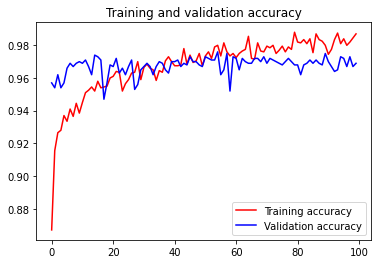

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()